In [2]:
from helper import get_training_data, train_lasso_regression, plot_result_correlation, get_best_lasso_model, train_xgboost,  get_best_pca_lasso_model, train_mean_model
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from helper import prepare_socios
from scipy import stats

%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Best models

#### Unemployment rate

In [3]:
# create required dataframes
results = pd.DataFrame(columns = ['improvement_lasso', 'improvement_lasso_boosted', 'improvement_pca_lasso', 'improvement_pca_lasso_boosted', 'improvement_mean_model'])
results_mse = pd.DataFrame(columns = ['mse_naive','mse_lasso', 'mse_lasso_boosted', 'mse_pca_lasso', 'mse_pca_lasso_boosted', 'mse_mean_model'])
results_r2 = pd.DataFrame(columns = ['r2_naive','r2_lasso', 'r2_lasso_boosted', 'r2_pca_lasso', 'r2_pca_lasso_boosted', 'r2_mean_model'])
p_list= []
full_residuals = pd.DataFrame(columns = ['residuals_naive', 'residuals_m5'])

# set target, feature type and radius
target = 'unemployment_rate'
dens_type = 'count'
radius = 1000

for city in ['marseille', 'lyon', 'paris']:
    #load data
    country = 'FR'
    agg = get_training_data(city, country, radius, dens_type,  2015)
    
    # Lasso:
    predicts = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='predicts')
    predicts_master = predicts.copy()
    predicts_master = predicts_master.rename(columns = {'y_pred': 'y_pred_lasso'})

    # Lasso Boosted
    cols = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='used_columns')
    predicts = train_xgboost(agg, target, cols, 'predicts')
    predicts_master.loc[:, 'y_pred_lasso_boosted'] = predicts.y_pred

    # PCA Lasso
    predicts = get_best_pca_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius,output = 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso'] = predicts.y_pred

    # PCA Lasso boosted
    comps = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius, output = 'components')
    cols = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius, output = 'used_columns')
    reduced_data = pd.DataFrame(comps)
    reduced_data = reduced_data.join(agg.iloc[:,-5:])
    predicts = train_xgboost(reduced_data, target, cols, 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso_boosted'] = predicts.y_pred

    # mean for M5
    predicts_master.loc[:, 'y_pred_mean_model'] = predicts_master[['y_pred_lasso_boosted', 'y_pred_pca_lasso_boosted']].mean(axis = 1)

    #compute residuals
    residuals = pd.DataFrame(columns = ['residuals_naive', 'residuals_m5'])
    residuals.loc[:,'residuals_naive'] = (predicts_master.y_test-predicts_master.naive)**2
    residuals.loc[:,'residuals_m5'] = (predicts_master.y_test-predicts_master.y_pred_mean_model)**2
    
    full_residuals = pd.concat([full_residuals, residuals])
    
    #reverse data scaling
    targets = ['unemployment_rate', 'income_levels', 'foreign_nationals']
    scaler = get_training_data(city, country, radius, dens_type, 2015, 'scaler')
    scaler_new = RobustScaler()
    scaler_new.center_, scaler_new.scale_ = scaler.center_[targets.index(target)], scaler.scale_[targets.index(target)]
    predicts_master = pd.DataFrame(scaler_new.inverse_transform(predicts_master), columns =predicts_master.columns)

    # compute metrics
    naive_mse = metrics.mean_squared_error(predicts_master.y_test, predicts_master.naive) 
    mse_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso)
    mse_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    mse_pca_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    mse_pca_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    mse_mean_model = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_mean_model)
    
    naive_r2 = metrics.r2_score(predicts_master.y_test, predicts_master.naive) 
    r2_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso)
    r2_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    r2_pca_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    r2_pca_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    r2_mean_model = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_mean_model)

    improvement_lasso = 100 - (mse_lasso/naive_mse)*100
    improvement_lasso_boosted = 100 - (mse_lasso_boosted /naive_mse)*100
    improvement_pca_lasso = 100 - (mse_pca_lasso/naive_mse)*100
    improvement_pca_lasso_boosted = 100 - (mse_pca_lasso_boosted/naive_mse)*100
    improvement_mean_model = 100 - (mse_mean_model/naive_mse)*100
    results.loc[city,:]=[improvement_lasso, improvement_lasso_boosted, improvement_pca_lasso, improvement_pca_lasso_boosted, improvement_mean_model]
    results_mse.loc[city,:]=[naive_mse, mse_lasso, mse_lasso_boosted, mse_pca_lasso, mse_pca_lasso_boosted, mse_mean_model]
    results_r2.loc[city,:]=[naive_r2, r2_lasso, r2_lasso_boosted, r2_pca_lasso, r2_pca_lasso_boosted, r2_mean_model]
    
    
for city in ['hamburg', 'berlin', 'bremen']:
    #load data
    country = 'DE'
    agg = get_training_data(city, country, radius, dens_type,  2015)
    
    # Lasso:
    predicts = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='predicts')
    predicts_master = predicts.copy()
    predicts_master = predicts_master.rename(columns = {'y_pred': 'y_pred_lasso'})

    # Lasso Boosted
    cols = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='used_columns')
    predicts = train_xgboost(agg, target, cols, 'predicts')
    predicts_master.loc[:, 'y_pred_lasso_boosted'] = predicts.y_pred

    # PCA Lasso
    predicts = get_best_pca_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius,output = 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso'] = predicts.y_pred

    # PCA Lasso boosted
    comps = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius, output = 'components')
    cols = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output = 'used_columns')
    reduced_data = pd.DataFrame(comps)
    reduced_data = reduced_data.join(agg.iloc[:,-5:])
    predicts = train_xgboost(reduced_data, target, cols, 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso_boosted'] = predicts.y_pred

    # get mean for M5
    predicts_master.loc[:, 'y_pred_mean_model'] = predicts_master[['y_pred_lasso_boosted', 'y_pred_pca_lasso_boosted']].mean(axis = 1)

    #compute residuals
    residuals = pd.DataFrame(columns = ['residuals_naive', 'residuals_m5'])
    residuals.loc[:,'residuals_naive'] = (predicts_master.y_test-predicts_master.naive)**2
    residuals.loc[:,'residuals_m5'] = (predicts_master.y_test-predicts_master.y_pred_mean_model)**2
    
    full_residuals = pd.concat([full_residuals, residuals])
    
    # reverse scaling
    targets = ['unemployment_rate', 'income_levels', 'foreign_nationals']
    scaler = get_training_data(city, country, radius, dens_type, 2015, 'scaler')
    scaler_new = RobustScaler()
    scaler_new.center_, scaler_new.scale_ = scaler.center_[targets.index(target)], scaler.scale_[targets.index(target)]
    predicts_master = pd.DataFrame(scaler_new.inverse_transform(predicts_master), columns =predicts_master.columns)

    #compute metrics
    naive_mse = metrics.mean_squared_error(predicts_master.y_test, predicts_master.naive) 
    mse_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso)
    mse_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    mse_pca_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    mse_pca_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    mse_mean_model = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_mean_model)
    
    naive_r2 = metrics.r2_score(predicts_master.y_test, predicts_master.naive) 
    r2_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso)
    r2_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    r2_pca_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    r2_pca_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    r2_mean_model = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_mean_model)

    improvement_lasso = 100 - (mse_lasso/naive_mse)*100
    improvement_lasso_boosted = 100 - (mse_lasso_boosted /naive_mse)*100
    improvement_pca_lasso = 100 - (mse_pca_lasso/naive_mse)*100
    improvement_pca_lasso_boosted = 100 - (mse_pca_lasso_boosted/naive_mse)*100
    improvement_mean_model = 100 - (mse_mean_model/naive_mse)*100
    results.loc[city,:]=[improvement_lasso, improvement_lasso_boosted, improvement_pca_lasso, improvement_pca_lasso_boosted, improvement_mean_model]
    results_mse.loc[city,:]=[naive_mse, mse_lasso, mse_lasso_boosted, mse_pca_lasso, mse_pca_lasso_boosted, mse_mean_model]
    results_r2.loc[city,:]=[naive_r2, r2_lasso, r2_lasso_boosted, r2_pca_lasso, r2_pca_lasso_boosted, r2_mean_model]
    
    
#results.loc['mean'] = results.mean()
results

shape of training data (344, 243)
0.1
0.1
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.1
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.1
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.1
shape of training data (344, 243)
shape of training data (176, 243)
0.2
0.2
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape of training data (176, 243)
shape of training data (861, 243)
0.01
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)

,improvement_lasso,improvement_lasso_boosted,improvement_pca_lasso,improvement_pca_lasso_boosted,improvement_mean_model
marseille,41.680482,35.214125,44.438605,46.358819,46.929571
lyon,22.838334,41.320281,22.907843,40.834638,42.387262
paris,33.17937,36.796983,35.57732,29.094963,36.334713
hamburg,40.074417,50.268429,33.66026,41.923217,50.256995
berlin,30.558282,32.080985,30.441039,37.696938,38.398618
bremen,40.244172,54.756016,48.18371,46.799312,56.940528


In [4]:
results_r2#unemployment

,r2_naive,r2_lasso,r2_lasso_boosted,r2_pca_lasso,r2_pca_lasso_boosted,r2_mean_model
marseille,-0.001364,0.41601,0.351258,0.443628,0.462857,0.468572
lyon,-0.001873,0.226938,0.412104,0.227634,0.407238,0.422793
paris,-0.014116,0.322361,0.359048,0.346679,0.28094,0.35436
hamburg,-0.124421,0.326184,0.440808,0.254062,0.346973,0.440679
berlin,-0.00026,0.305402,0.320633,0.30423,0.376808,0.383826
bremen,-0.043206,0.376624,0.528012,0.459449,0.445007,0.550801


In [5]:
results_mse

,mse_naive,mse_lasso,mse_lasso_boosted,mse_pca_lasso,mse_pca_lasso_boosted,mse_mean_model
marseille,0.010888,0.00635,0.007054,0.006049,0.00584,0.005778
lyon,0.002615,0.002018,0.001534,0.002016,0.001547,0.001506
paris,0.001694,0.001132,0.001071,0.001091,0.001201,0.001079
hamburg,0.000365,0.000219,0.000181,0.000242,0.000212,0.000181
berlin,0.000859,0.000596,0.000583,0.000597,0.000535,0.000529
bremen,0.001918,0.001146,0.000868,0.000994,0.001021,0.000826


In [6]:
results_rmse = results_mse**(0.5)
results_rmse = results_rmse.rename(columns = {'mse_naive': 'rmse_naive','mse_lasso':'rmse_lasso', 'mse_lasso_boosted':'rmse_lasso_boosted', 'mse_pca_lasso':'rmse_pca_lasso', 'mse_pca_lasso_boosted':'rmse_pca_lasso_boosted', 'mse_mean_model':'rmse_mean_model'})
results_rmse

,rmse_naive,rmse_lasso,rmse_lasso_boosted,rmse_pca_lasso,rmse_pca_lasso_boosted,rmse_mean_model
marseille,0.104344,0.079684,0.083986,0.077777,0.076421,0.076014
lyon,0.051135,0.044918,0.039171,0.044898,0.039333,0.038813
paris,0.041161,0.033646,0.032723,0.033037,0.03466,0.032842
hamburg,0.0191,0.014786,0.01347,0.015557,0.014556,0.013471
berlin,0.029304,0.02442,0.02415,0.02444,0.02313,0.023
bremen,0.043799,0.033858,0.029461,0.031528,0.031947,0.028741


In [7]:
#TTest on resiudals
t_stat, p = stats.ttest_ind(full_residuals['residuals_naive'], full_residuals['residuals_m5'])
print(f'TTest: t={t_stat}, p={p}')

TTest: t=3.4650682431293243, p=0.0005621455459970153


In [6]:
#store all data and export it
output = pd.concat([results, results_r2, results_mse, results_rmse], axis = 1, join = 'inner')
output = output[['mse_naive', 'rmse_naive', 'r2_naive',
               'mse_lasso', 'rmse_lasso', 'r2_lasso', 'improvement_lasso',
               'mse_lasso_boosted', 'rmse_lasso_boosted', 'r2_lasso_boosted', 'improvement_lasso_boosted',
               'mse_pca_lasso', 'rmse_pca_lasso', 'r2_pca_lasso', 'improvement_pca_lasso',
               'mse_pca_lasso_boosted', 'rmse_pca_lasso_boosted', 'r2_pca_lasso_boosted', 'improvement_pca_lasso_boosted',
               'mse_mean_model', 'rmse_mean_model', 'r2_mean_model', 'improvement_mean_model']]
output.to_excel(f'output/results/results_{target}_{dens_type}_{radius}.xlsx')
output

,mse_naive,rmse_naive,r2_naive,mse_lasso,rmse_lasso,r2_lasso,improvement_lasso,mse_lasso_boosted,rmse_lasso_boosted,r2_lasso_boosted,...,r2_pca_lasso,improvement_pca_lasso,mse_pca_lasso_boosted,rmse_pca_lasso_boosted,r2_pca_lasso_boosted,improvement_pca_lasso_boosted,mse_mean_model,rmse_mean_model,r2_mean_model,improvement_mean_model
marseille,0.010888,0.104344,-0.001364,0.00635,0.079684,0.41601,41.680482,0.007054,0.083986,0.351258,...,0.443628,44.438605,0.00584,0.076421,0.462857,46.358819,0.005778,0.076014,0.468572,46.929571
lyon,0.002615,0.051135,-0.001873,0.002018,0.044918,0.226938,22.838334,0.001534,0.039171,0.412104,...,0.227634,22.907843,0.001547,0.039333,0.407238,40.834638,0.001506,0.038813,0.422793,42.387262
paris,0.001694,0.041161,-0.014116,0.001132,0.033646,0.322361,33.17937,0.001071,0.032723,0.359048,...,0.346679,35.57732,0.001201,0.03466,0.28094,29.094963,0.001079,0.032842,0.35436,36.334713
hamburg,0.000365,0.0191,-0.124421,0.000219,0.014786,0.326184,40.074417,0.000181,0.01347,0.440808,...,0.254062,33.66026,0.000212,0.014556,0.346973,41.923217,0.000181,0.013471,0.440679,50.256995
berlin,0.000859,0.029304,-0.00026,0.000596,0.02442,0.305402,30.558282,0.000583,0.02415,0.320633,...,0.30423,30.441039,0.000535,0.02313,0.376808,37.696938,0.000529,0.023,0.383826,38.398618
bremen,0.001918,0.043799,-0.043206,0.001146,0.033858,0.376624,40.244172,0.000868,0.029461,0.528012,...,0.459449,48.18371,0.001021,0.031947,0.445007,46.799312,0.000826,0.028741,0.550801,56.940528


#### Foreign Nationals

In [8]:
#create dataframes and set target, radius and feature type
results = pd.DataFrame(columns = ['improvement_lasso', 'improvement_lasso_boosted', 'improvement_pca_lasso', 'improvement_pca_lasso_boosted', 'improvement_mean_model'])
results_mse = pd.DataFrame(columns = ['mse_naive','mse_lasso', 'mse_lasso_boosted', 'mse_pca_lasso', 'mse_pca_lasso_boosted', 'mse_mean_model'])
results_r2 = pd.DataFrame(columns = ['r2_naive','r2_lasso', 'r2_lasso_boosted', 'r2_pca_lasso', 'r2_pca_lasso_boosted', 'r2_mean_model'])
full_residuals_fn = pd.DataFrame(columns = ['residuals_naive', 'residuals_m5'])
target = 'foreign_nationals'
dens_type = 'count'
radius = 1000


for city in ['marseille', 'lyon', 'paris']:
    #load data
    country = 'FR'
    agg = get_training_data(city, country, radius, dens_type,  2015)
    
    # Lasso:
    predicts = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='predicts')
    predicts_master = predicts.copy()
    predicts_master = predicts_master.rename(columns = {'y_pred': 'y_pred_lasso'})

    # Lasso Boosted
    cols = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='used_columns')
    predicts = train_xgboost(agg, target, cols, 'predicts')
    predicts_master.loc[:, 'y_pred_lasso_boosted'] = predicts.y_pred

    # PCA Lasso
    predicts = get_best_pca_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius,output = 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso'] = predicts.y_pred

    # PCA Lasso boosted
    comps = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius, output = 'components')
    cols = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius, output = 'used_columns')
    reduced_data = pd.DataFrame(comps)
    reduced_data = reduced_data.join(agg.iloc[:,-5:])
    predicts = train_xgboost(reduced_data, target, cols, 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso_boosted'] = predicts.y_pred

    #get mean for M5
    predicts_master.loc[:, 'y_pred_mean_model'] = predicts_master[['y_pred_lasso_boosted', 'y_pred_pca_lasso_boosted']].mean(axis = 1)

    #Compute residuals
    residuals = pd.DataFrame(columns = ['residuals_naive', 'residuals_m5'])
    residuals.loc[:,'residuals_naive'] = (predicts_master.y_test-predicts_master.naive)**2
    residuals.loc[:,'residuals_m5'] = (predicts_master.y_test-predicts_master.y_pred_mean_model)**2
    
    full_residuals_fn = pd.concat([full_residuals_fn, residuals])
    
    #reverse scaling
    targets = ['unemployment_rate', 'income_levels', 'foreign_nationals']
    scaler = get_training_data(city, country, radius, dens_type, 2015, 'scaler')
    scaler_new = RobustScaler()
    scaler_new.center_, scaler_new.scale_ = scaler.center_[targets.index(target)], scaler.scale_[targets.index(target)]
    predicts_master = pd.DataFrame(scaler_new.inverse_transform(predicts_master), columns =predicts_master.columns)

    #compute metrics
    naive_mse = metrics.mean_squared_error(predicts_master.y_test, predicts_master.naive) 
    mse_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso)
    mse_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    mse_pca_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    mse_pca_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    mse_mean_model = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_mean_model)
    
    naive_r2 = metrics.r2_score(predicts_master.y_test, predicts_master.naive) 
    r2_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso)
    r2_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    r2_pca_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    r2_pca_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    r2_mean_model = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_mean_model)

    improvement_lasso = 100 - (mse_lasso/naive_mse)*100
    improvement_lasso_boosted = 100 - (mse_lasso_boosted /naive_mse)*100
    improvement_pca_lasso = 100 - (mse_pca_lasso/naive_mse)*100
    improvement_pca_lasso_boosted = 100 - (mse_pca_lasso_boosted/naive_mse)*100
    improvement_mean_model = 100 - (mse_mean_model/naive_mse)*100
    results.loc[city,:]=[improvement_lasso, improvement_lasso_boosted, improvement_pca_lasso, improvement_pca_lasso_boosted, improvement_mean_model]
    results_mse.loc[city,:]=[naive_mse, mse_lasso, mse_lasso_boosted, mse_pca_lasso, mse_pca_lasso_boosted, mse_mean_model]
    results_r2.loc[city,:]=[naive_r2, r2_lasso, r2_lasso_boosted, r2_pca_lasso, r2_pca_lasso_boosted, r2_mean_model]

    
for city in ['hamburg', 'berlin', 'bremen']:
    #load data
    country = 'DE'
    agg = get_training_data(city, country, radius, dens_type,  2015)
    
    # Lasso:
    predicts = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='predicts')
    predicts_master = predicts.copy()
    predicts_master = predicts_master.rename(columns = {'y_pred': 'y_pred_lasso'})

    # Lasso Boosted
    cols = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='used_columns')
    predicts = train_xgboost(agg, target, cols, 'predicts')
    predicts_master.loc[:, 'y_pred_lasso_boosted'] = predicts.y_pred

    # PCA Lasso
    predicts = get_best_pca_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius,output = 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso'] = predicts.y_pred

    # PCA Lasso boosted
    comps = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius, output = 'components')
    cols = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output = 'used_columns')
    reduced_data = pd.DataFrame(comps)
    reduced_data = reduced_data.join(agg.iloc[:,-5:])
    predicts = train_xgboost(reduced_data, target, cols, 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso_boosted'] = predicts.y_pred

    #get mean for M5
    predicts_master.loc[:, 'y_pred_mean_model'] = predicts_master[['y_pred_lasso_boosted', 'y_pred_pca_lasso_boosted']].mean(axis = 1)

    #compute residuals
    residuals = pd.DataFrame(columns = ['residuals_naive', 'residuals_m5'])
    residuals.loc[:,'residuals_naive'] = (predicts_master.y_test-predicts_master.naive)**2
    residuals.loc[:,'residuals_m5'] = (predicts_master.y_test-predicts_master.y_pred_mean_model)**2
    
    full_residuals_fn = pd.concat([full_residuals_fn, residuals])
    
    #reverse scaling
    targets = ['unemployment_rate', 'income_levels', 'foreign_nationals']
    scaler = get_training_data(city, country, radius, dens_type, 2015, 'scaler')
    scaler_new = RobustScaler()
    scaler_new.center_, scaler_new.scale_ = scaler.center_[targets.index(target)], scaler.scale_[targets.index(target)]
    predicts_master = pd.DataFrame(scaler_new.inverse_transform(predicts_master), columns =predicts_master.columns)

    #compute performance metrics
    naive_mse = metrics.mean_squared_error(predicts_master.y_test, predicts_master.naive) 
    mse_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso)
    mse_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    mse_pca_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    mse_pca_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    mse_mean_model = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_mean_model)
    
    naive_r2 = metrics.r2_score(predicts_master.y_test, predicts_master.naive) 
    r2_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso)
    r2_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    r2_pca_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    r2_pca_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    r2_mean_model = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_mean_model)

    improvement_lasso = 100 - (mse_lasso/naive_mse)*100
    improvement_lasso_boosted = 100 - (mse_lasso_boosted /naive_mse)*100
    improvement_pca_lasso = 100 - (mse_pca_lasso/naive_mse)*100
    improvement_pca_lasso_boosted = 100 - (mse_pca_lasso_boosted/naive_mse)*100
    improvement_mean_model = 100 - (mse_mean_model/naive_mse)*100
    results.loc[city,:]=[improvement_lasso, improvement_lasso_boosted, improvement_pca_lasso, improvement_pca_lasso_boosted, improvement_mean_model]
    results_mse.loc[city,:]=[naive_mse, mse_lasso, mse_lasso_boosted, mse_pca_lasso, mse_pca_lasso_boosted, mse_mean_model]
    results_r2.loc[city,:]=[naive_r2, r2_lasso, r2_lasso_boosted, r2_pca_lasso, r2_pca_lasso_boosted, r2_mean_model]

    
#results.loc['mean'] = results.mean()
results

shape of training data (344, 243)
0.01
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape of training data (344, 243)
shape of training data (176, 243)
0.1
0.1
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape of training data (176, 243)
shape of training data (861, 243)
0.01
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861,

,improvement_lasso,improvement_lasso_boosted,improvement_pca_lasso,improvement_pca_lasso_boosted,improvement_mean_model
marseille,70.37185,75.275179,72.938022,63.059867,72.405118
lyon,26.652563,25.031563,26.075534,26.925843,27.669349
paris,30.349951,34.698283,30.145525,30.013002,35.326112
hamburg,41.669386,11.528567,24.711452,-4.445448,25.432159
berlin,62.771734,59.713055,56.644192,64.859589,67.603515
bremen,19.852717,29.928093,19.422933,28.074484,32.320905


In [9]:
results_r2#foreign nationals

,r2_naive,r2_lasso,r2_lasso_boosted,r2_pca_lasso,r2_pca_lasso_boosted,r2_mean_model
marseille,-0.026125,0.695978,0.746292,0.72231,0.620948,0.716842
lyon,-0.002119,0.264972,0.248727,0.259189,0.26771,0.275161
paris,-0.021716,0.288374,0.332802,0.286286,0.284932,0.339217
hamburg,-0.26129,0.264282,-0.115881,0.050393,-0.31736,0.059483
berlin,-0.033907,0.615094,0.58347,0.551741,0.636681,0.66505
bremen,-0.012699,0.18835,0.290383,0.183997,0.271611,0.314615


In [10]:
results_mse

,mse_naive,mse_lasso,mse_lasso_boosted,mse_pca_lasso,mse_pca_lasso_boosted,mse_mean_model
marseille,0.009139,0.002708,0.002259,0.002473,0.003376,0.002522
lyon,0.002496,0.001831,0.001871,0.001845,0.001824,0.001806
paris,0.002873,0.002001,0.001876,0.002007,0.002011,0.001858
hamburg,0.005245,0.003059,0.00464,0.003949,0.005478,0.003911
berlin,0.003961,0.001475,0.001596,0.001717,0.001392,0.001283
bremen,0.006663,0.00534,0.004669,0.005369,0.004793,0.00451


In [11]:
results_rmse = results_mse**(0.5)
results_rmse = results_rmse.rename(columns = {'mse_naive': 'rmse_naive','mse_lasso':'rmse_lasso', 'mse_lasso_boosted':'rmse_lasso_boosted', 'mse_pca_lasso':'rmse_pca_lasso', 'mse_pca_lasso_boosted':'rmse_pca_lasso_boosted', 'mse_mean_model':'rmse_mean_model'})
results_rmse

,rmse_naive,rmse_lasso,rmse_lasso_boosted,rmse_pca_lasso,rmse_pca_lasso_boosted,rmse_mean_model
marseille,0.095596,0.052034,0.047534,0.04973,0.058102,0.050217
lyon,0.049962,0.042789,0.043259,0.042957,0.042709,0.042492
paris,0.053601,0.044734,0.043315,0.044799,0.044842,0.043106
hamburg,0.072423,0.055312,0.06812,0.06284,0.074015,0.062539
berlin,0.062939,0.038402,0.039949,0.041443,0.03731,0.035824
bremen,0.081628,0.073078,0.06833,0.073274,0.069228,0.067153


In [12]:
#TTest on resiudals
t_stat, p = stats.ttest_ind(full_residuals_fn['residuals_naive'], full_residuals_fn['residuals_m5'])
print(f'TTest: t={t_stat}, p={p}')

TTest: t=3.347953632715851, p=0.0008573010577670957


In [12]:
#data export
output = pd.concat([results, results_r2, results_mse, results_rmse], axis = 1, join = 'inner')
output = output[['mse_naive', 'rmse_naive', 'r2_naive',
               'mse_lasso', 'rmse_lasso', 'r2_lasso', 'improvement_lasso',
               'mse_lasso_boosted', 'rmse_lasso_boosted', 'r2_lasso_boosted', 'improvement_lasso_boosted',
               'mse_pca_lasso', 'rmse_pca_lasso', 'r2_pca_lasso', 'improvement_pca_lasso',
               'mse_pca_lasso_boosted', 'rmse_pca_lasso_boosted', 'r2_pca_lasso_boosted', 'improvement_pca_lasso_boosted',
               'mse_mean_model', 'rmse_mean_model', 'r2_mean_model', 'improvement_mean_model']]
output.to_excel(f'output/results/results_{target}_{dens_type}_{radius}.xlsx')
output

,mse_naive,rmse_naive,r2_naive,mse_lasso,rmse_lasso,r2_lasso,improvement_lasso,mse_lasso_boosted,rmse_lasso_boosted,r2_lasso_boosted,...,r2_pca_lasso,improvement_pca_lasso,mse_pca_lasso_boosted,rmse_pca_lasso_boosted,r2_pca_lasso_boosted,improvement_pca_lasso_boosted,mse_mean_model,rmse_mean_model,r2_mean_model,improvement_mean_model
marseille,0.009139,0.095596,-0.026125,0.002708,0.052034,0.695978,70.37185,0.002259,0.047534,0.746292,...,0.72231,72.938022,0.003376,0.058102,0.620948,63.059867,0.002522,0.050217,0.716842,72.405118
lyon,0.002496,0.049962,-0.002119,0.001831,0.042789,0.264972,26.652563,0.001871,0.043259,0.248727,...,0.259189,26.075534,0.001824,0.042709,0.26771,26.925843,0.001806,0.042492,0.275161,27.669349
paris,0.002873,0.053601,-0.021716,0.002001,0.044734,0.288374,30.349951,0.001876,0.043315,0.332802,...,0.286286,30.145525,0.002011,0.044842,0.284932,30.013002,0.001858,0.043106,0.339217,35.326112
hamburg,0.005245,0.072423,-0.26129,0.003059,0.055312,0.264282,41.669386,0.00464,0.06812,-0.115881,...,0.050393,24.711452,0.005478,0.074015,-0.31736,-4.445448,0.003911,0.062539,0.059483,25.432159
berlin,0.003961,0.062939,-0.033907,0.001475,0.038402,0.615094,62.771734,0.001596,0.039949,0.58347,...,0.551741,56.644192,0.001392,0.03731,0.636681,64.859589,0.001283,0.035824,0.66505,67.603515
bremen,0.006663,0.081628,-0.012699,0.00534,0.073078,0.18835,19.852717,0.004669,0.06833,0.290383,...,0.183997,19.422933,0.004793,0.069228,0.271611,28.074484,0.00451,0.067153,0.314615,32.320905


#### Income levels

In [13]:
#create dataframes and set target, radius and feature type
results = pd.DataFrame(columns = ['improvement_lasso', 'improvement_lasso_boosted', 'improvement_pca_lasso', 'improvement_pca_lasso_boosted', 'improvement_mean_model'])
results_mse = pd.DataFrame(columns = ['mse_naive','mse_lasso', 'mse_lasso_boosted', 'mse_pca_lasso', 'mse_pca_lasso_boosted', 'mse_mean_model'])
results_r2 = pd.DataFrame(columns = ['r2_naive','r2_lasso', 'r2_lasso_boosted', 'r2_pca_lasso', 'r2_pca_lasso_boosted', 'r2_mean_model'])
full_residuals_income = pd.DataFrame(columns = ['residuals_naive', 'residuals_m5'])
target = 'income_levels'
dens_type = 'count'
radius = 1000


for city in ['marseille', 'lyon', 'paris']:
    #load data
    country = 'FR'
    agg = get_training_data(city, country, radius, dens_type,  2015)
    
    # Lasso:
    predicts = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='predicts')
    predicts_master = predicts.copy()
    predicts_master = predicts_master.rename(columns = {'y_pred': 'y_pred_lasso'})

    # Lasso Boosted
    cols = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='used_columns')
    predicts = train_xgboost(agg, target, cols, 'predicts')
    predicts_master.loc[:, 'y_pred_lasso_boosted'] = predicts.y_pred

    # PCA Lasso
    predicts = get_best_pca_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius,output = 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso'] = predicts.y_pred

    # PCA Lasso boosted
    comps = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius, output = 'components')
    cols = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius, output = 'used_columns')
    reduced_data = pd.DataFrame(comps)
    reduced_data = reduced_data.join(agg.iloc[:,-5:])
    predicts = train_xgboost(reduced_data, target, cols, 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso_boosted'] = predicts.y_pred

    #get mean for M5
    predicts_master.loc[:, 'y_pred_mean_model'] = predicts_master[['y_pred_lasso_boosted', 'y_pred_pca_lasso_boosted']].mean(axis = 1)

    #compute residuals
    residuals = pd.DataFrame(columns = ['residuals_naive', 'residuals_m5'])
    residuals.loc[:,'residuals_naive'] = (predicts_master.y_test-predicts_master.naive)**2
    residuals.loc[:,'residuals_m5'] = (predicts_master.y_test-predicts_master.y_pred_mean_model)**2
    
    full_residuals_income = pd.concat([full_residuals_income, residuals])
    
    #reverse data scaling
    targets = ['unemployment_rate', 'income_levels', 'foreign_nationals']
    scaler = get_training_data(city, country, radius, dens_type, 2015, 'scaler')
    scaler_new = RobustScaler()
    scaler_new.center_, scaler_new.scale_ = scaler.center_[targets.index(target)], scaler.scale_[targets.index(target)]
    predicts_master = pd.DataFrame(scaler_new.inverse_transform(predicts_master), columns =predicts_master.columns)

    #compute performance metrics
    naive_mse = metrics.mean_squared_error(predicts_master.y_test, predicts_master.naive) 
    mse_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso)
    mse_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    mse_pca_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    mse_pca_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    mse_mean_model = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_mean_model)
    
    naive_r2 = metrics.r2_score(predicts_master.y_test, predicts_master.naive) 
    r2_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso)
    r2_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    r2_pca_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    r2_pca_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    r2_mean_model = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_mean_model)

    improvement_lasso = 100 - (mse_lasso/naive_mse)*100
    improvement_lasso_boosted = 100 - (mse_lasso_boosted /naive_mse)*100
    improvement_pca_lasso = 100 - (mse_pca_lasso/naive_mse)*100
    improvement_pca_lasso_boosted = 100 - (mse_pca_lasso_boosted/naive_mse)*100
    improvement_mean_model = 100 - (mse_mean_model/naive_mse)*100
    results.loc[city,:]=[improvement_lasso, improvement_lasso_boosted, improvement_pca_lasso, improvement_pca_lasso_boosted, improvement_mean_model]
    results_mse.loc[city,:]=[naive_mse, mse_lasso, mse_lasso_boosted, mse_pca_lasso, mse_pca_lasso_boosted, mse_mean_model]
    results_r2.loc[city,:]=[naive_r2, r2_lasso, r2_lasso_boosted, r2_pca_lasso, r2_pca_lasso_boosted, r2_mean_model]
    

    
for city in ['hamburg', 'berlin', 'bremen']:
    #load data
    country = 'DE'
    agg = get_training_data(city, country, radius, dens_type,  2015)
    
    # Lasso:
    predicts = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='predicts')
    predicts_master = predicts.copy()
    predicts_master = predicts_master.rename(columns = {'y_pred': 'y_pred_lasso'})

    # Lasso Boosted
    cols = get_best_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output ='used_columns')
    predicts = train_xgboost(agg, target, cols, 'predicts')
    predicts_master.loc[:, 'y_pred_lasso_boosted'] = predicts.y_pred

    # PCA Lasso
    predicts = get_best_pca_lasso_model(agg=agg, target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius,output = 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso'] = predicts.y_pred

    # PCA Lasso boosted
    comps = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015,  density_type=dens_type, radius = radius, output = 'components')
    cols = get_best_pca_lasso_model(agg=agg,target=target, city=city, country=country, socio_year=2015, density_type=dens_type, radius = radius, output = 'used_columns')
    reduced_data = pd.DataFrame(comps)
    reduced_data = reduced_data.join(agg.iloc[:,-5:])
    predicts = train_xgboost(reduced_data, target, cols, 'predicts')
    predicts_master.loc[:,'y_pred_pca_lasso_boosted'] = predicts.y_pred

    #predicts_master.loc[:, 'y_pred_mean_model'] = predicts_master[['y_pred_lasso', 'y_pred_lasso_boosted', 'y_pred_pca_lasso', 'y_pred_pca_lasso_boosted']].mean(axis = 1)
    predicts_master.loc[:, 'y_pred_mean_model'] = predicts_master[['y_pred_lasso_boosted', 'y_pred_pca_lasso_boosted']].mean(axis = 1)

    #compute residuals
    residuals = pd.DataFrame(columns = ['residuals_naive', 'residuals_m5'])
    residuals.loc[:,'residuals_naive'] = (predicts_master.y_test-predicts_master.naive)**2
    residuals.loc[:,'residuals_m5'] = (predicts_master.y_test-predicts_master.y_pred_mean_model)**2
    
    full_residuals_income = pd.concat([full_residuals_income, residuals])
    
    #reverse data scaling
    targets = ['unemployment_rate', 'income_levels', 'foreign_nationals']
    scaler = get_training_data(city, country, radius, dens_type, 2015, 'scaler')
    scaler_new = RobustScaler()
    scaler_new.center_, scaler_new.scale_ = scaler.center_[targets.index(target)], scaler.scale_[targets.index(target)]
    predicts_master = pd.DataFrame(scaler_new.inverse_transform(predicts_master), columns =predicts_master.columns)

    # compute performance metrics
    naive_mse = metrics.mean_squared_error(predicts_master.y_test, predicts_master.naive) 
    mse_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso)
    mse_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    mse_pca_lasso = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    mse_pca_lasso_boosted = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    mse_mean_model = metrics.mean_squared_error(predicts_master.y_test, predicts_master.y_pred_mean_model)
    
    naive_r2 = metrics.r2_score(predicts_master.y_test, predicts_master.naive) 
    r2_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso)
    r2_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_lasso_boosted)
    r2_pca_lasso = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso)
    r2_pca_lasso_boosted = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_pca_lasso_boosted)
    r2_mean_model = metrics.r2_score(predicts_master.y_test, predicts_master.y_pred_mean_model)

    improvement_lasso = 100 - (mse_lasso/naive_mse)*100
    improvement_lasso_boosted = 100 - (mse_lasso_boosted /naive_mse)*100
    improvement_pca_lasso = 100 - (mse_pca_lasso/naive_mse)*100
    improvement_pca_lasso_boosted = 100 - (mse_pca_lasso_boosted/naive_mse)*100
    improvement_mean_model = 100 - (mse_mean_model/naive_mse)*100
    results.loc[city,:]=[improvement_lasso, improvement_lasso_boosted, improvement_pca_lasso, improvement_pca_lasso_boosted, improvement_mean_model]
    results_mse.loc[city,:]=[naive_mse, mse_lasso, mse_lasso_boosted, mse_pca_lasso, mse_pca_lasso_boosted, mse_mean_model]
    results_r2.loc[city,:]=[naive_r2, r2_lasso, r2_lasso_boosted, r2_pca_lasso, r2_pca_lasso_boosted, r2_mean_model]
       
#results.loc['mean'] = results.mean()
results

shape of training data (344, 243)
0.01
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape of training data (344, 243)
shape of training data (176, 243)
0.1
0.1
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.1
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.1
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.1
shape of training data (176, 243)
shape of training data (861, 243)
0.01
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861,

,improvement_lasso,improvement_lasso_boosted,improvement_pca_lasso,improvement_pca_lasso_boosted,improvement_mean_model
marseille,74.639366,74.491927,76.171372,67.429672,75.309903
lyon,42.887151,52.348249,48.834856,53.140459,57.652806
paris,71.30661,75.369685,71.739564,70.404145,74.625626
hamburg,38.956691,37.21714,36.641392,39.778275,47.218826
berlin,17.489254,39.874772,-27.711928,-22.642964,29.731272
bremen,32.959338,40.586651,31.282117,40.09886,45.940758


In [14]:
results_r2#income levels

,r2_naive,r2_lasso,r2_lasso_boosted,r2_pca_lasso,r2_pca_lasso_boosted,r2_mean_model
marseille,-0.000792,0.746193,0.744717,0.761525,0.674039,0.752903
lyon,-0.000858,0.428381,0.523073,0.487909,0.531002,0.576165
paris,-0.005564,0.71147,0.752326,0.715823,0.702395,0.744844
hamburg,-0.042585,0.363572,0.345436,0.339433,0.372138,0.449712
berlin,-0.001062,0.174016,0.398109,-0.278476,-0.227733,0.296566
bremen,-0.205356,0.191921,0.283858,0.171705,0.277978,0.348394


In [15]:
results_mse

,mse_naive,mse_lasso,mse_lasso_boosted,mse_pca_lasso,mse_pca_lasso_boosted,mse_mean_model
marseille,361248.317935,91614.863765,92147.484676,86080.519236,117659.760747,89192.560479
lyon,244401.878031,139584.874445,116461.773642,125048.573088,114525.59882,103497.3381
paris,840140.3386,241064.743189,206929.208861,237427.324887,248646.716541,213180.354353
hamburg,667237.806043,407304.032396,418910.978417,422752.587952,401822.113891,352175.950401
berlin,731046.943231,603192.289891,439543.640732,933634.145608,896577.641375,513697.385316
bremen,626827.178684,420229.092606,372419.020751,430742.366263,375476.626216,338858.019679


In [16]:
results_rmse = results_mse**(0.5)
results_rmse = results_rmse.rename(columns = {'mse_naive': 'rmse_naive','mse_lasso':'rmse_lasso', 'mse_lasso_boosted':'rmse_lasso_boosted', 'mse_pca_lasso':'rmse_pca_lasso', 'mse_pca_lasso_boosted':'rmse_pca_lasso_boosted', 'mse_mean_model':'rmse_mean_model'})
results_rmse

,rmse_naive,rmse_lasso,rmse_lasso_boosted,rmse_pca_lasso,rmse_pca_lasso_boosted,rmse_mean_model
marseille,601.039365,302.679474,303.558042,293.394818,343.015686,298.651236
lyon,494.370183,373.610592,341.264961,353.622077,338.41631,321.710022
paris,916.591697,490.983445,454.894723,487.265148,498.64488,461.714581
hamburg,816.846256,638.203755,647.233326,650.194269,633.894403,593.444143
berlin,855.012832,776.65455,662.980875,966.247456,946.877839,716.726855
bremen,791.724181,648.250795,610.261436,656.309657,612.761476,582.115126


In [17]:
#perform TTest on residuals
t_stat, p = stats.ttest_ind(full_residuals_income['residuals_naive'], full_residuals_income['residuals_m5'])
print(f'TTest: t={t_stat}, p={p}')

TTest: t=8.085510005642824, p=2.6924211701562835e-15


In [17]:
#data export
output = pd.concat([results, results_r2, results_mse, results_rmse], axis = 1, join = 'inner')
output = output[['mse_naive', 'rmse_naive', 'r2_naive',
               'mse_lasso', 'rmse_lasso', 'r2_lasso', 'improvement_lasso',
               'mse_lasso_boosted', 'rmse_lasso_boosted', 'r2_lasso_boosted', 'improvement_lasso_boosted',
               'mse_pca_lasso', 'rmse_pca_lasso', 'r2_pca_lasso', 'improvement_pca_lasso',
               'mse_pca_lasso_boosted', 'rmse_pca_lasso_boosted', 'r2_pca_lasso_boosted', 'improvement_pca_lasso_boosted',
               'mse_mean_model', 'rmse_mean_model', 'r2_mean_model', 'improvement_mean_model']]
output.to_excel(f'output/results/results_{target}_{dens_type}_{radius}.xlsx')
output

,mse_naive,rmse_naive,r2_naive,mse_lasso,rmse_lasso,r2_lasso,improvement_lasso,mse_lasso_boosted,rmse_lasso_boosted,r2_lasso_boosted,...,r2_pca_lasso,improvement_pca_lasso,mse_pca_lasso_boosted,rmse_pca_lasso_boosted,r2_pca_lasso_boosted,improvement_pca_lasso_boosted,mse_mean_model,rmse_mean_model,r2_mean_model,improvement_mean_model
marseille,361248.317935,601.039365,-0.000792,91614.863765,302.679474,0.746193,74.639366,92147.484676,303.558042,0.744717,...,0.761525,76.171372,117659.760747,343.015686,0.674039,67.429672,89192.560479,298.651236,0.752903,75.309903
lyon,244401.878031,494.370183,-0.000858,139584.874445,373.610592,0.428381,42.887151,116461.773642,341.264961,0.523073,...,0.487909,48.834856,114525.59882,338.41631,0.531002,53.140459,103497.3381,321.710022,0.576165,57.652806
paris,840140.3386,916.591697,-0.005564,241064.743189,490.983445,0.71147,71.30661,206929.208861,454.894723,0.752326,...,0.715823,71.739564,248646.716541,498.64488,0.702395,70.404145,213180.354353,461.714581,0.744844,74.625626
hamburg,667237.806043,816.846256,-0.042585,407304.032396,638.203755,0.363572,38.956691,418910.978417,647.233326,0.345436,...,0.339433,36.641392,401822.113891,633.894403,0.372138,39.778275,352175.950401,593.444143,0.449712,47.218826
berlin,731046.943231,855.012832,-0.001062,603192.289891,776.65455,0.174016,17.489254,439543.640732,662.980875,0.398109,...,-0.278476,-27.711928,896577.641375,946.877839,-0.227733,-22.642964,513697.385316,716.726855,0.296566,29.731272
bremen,626827.178684,791.724181,-0.205356,420229.092606,648.250795,0.191921,32.959338,372419.020751,610.261436,0.283858,...,0.171705,31.282117,375476.626216,612.761476,0.277978,40.09886,338858.019679,582.115126,0.348394,45.940758


## Load socios

In [11]:
socios = prepare_socios('all', 1000, 'count', 2015)

## Unemployment_rate

shape of training data (345, 243)
0.1
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.1
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.1
shape of training data (345, 243)
shape of training data (176, 243)
0.2
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape of training data (176, 243)
shape of training data (868, 243)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape of training data (868, 243)
shape of training data (122, 243)
0.1
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.2
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.2
shape of training data (122

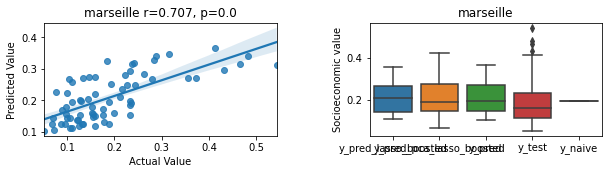

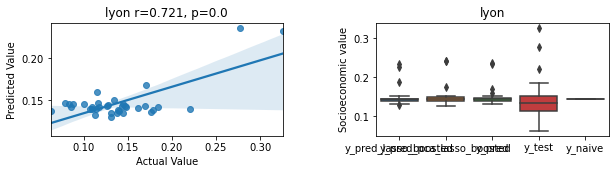

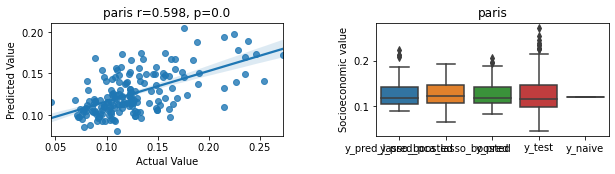

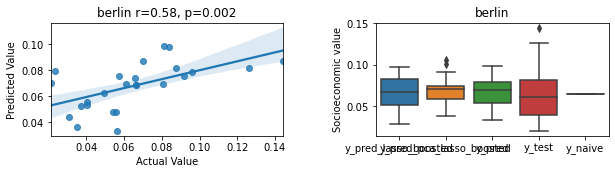

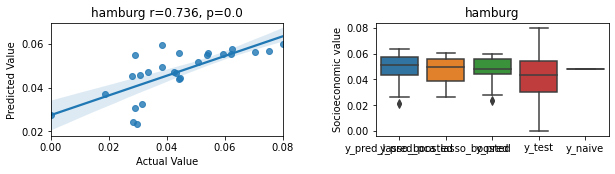

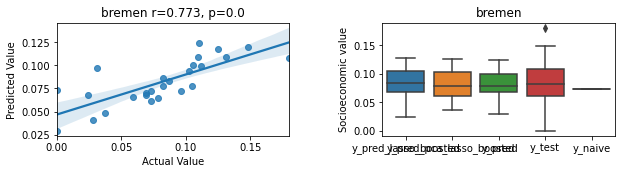

In [12]:
target = 'unemployment_rate'

# Marseille: PCA-Lasso-Boosted
city = 'marseille'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Lyon: lasso-boosted
city = 'lyon'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

#Paris: lasso boosted
city = 'paris'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Berlin: Lasso boosted:
city = 'berlin'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Hamburg: Lasso boosted:
city = 'hamburg'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Bremen: Lasso boosted:
city = 'bremen'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

marseille: 0.012371848946054078
lyon: 0.0030197789484638408
paris: 0.0018497422887644836
berlin: 0.0007089799663854573
hamburg: 0.0003822699889161084
bremen: 0.0011348908128367148


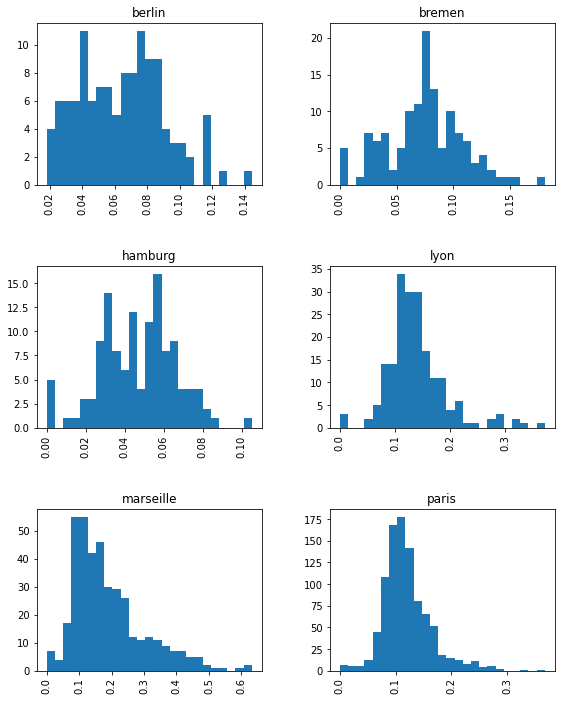

In [13]:
unemployment = socios[socios.types == 'unemployment_rate']
fig = plt.figure(figsize = (9,12))
ax = fig.gca()
unemployment.hist(column = 'relative_value', by='assigned_city', ax = ax, bins = 25)
for city in ['marseille', 'lyon', 'paris', 'berlin', 'hamburg', 'bremen']:
    print(str(city)+': '+str(unemployment[unemployment.assigned_city == city].relative_value.var()))

In [14]:
final_results = pd.DataFrame(columns = ['improvement','r2_score'])
target = 'unemployment_rate'

# Marseille: PCA-Lasso-Boosted
city = 'marseille'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Lyon: lasso-boosted
city = 'lyon'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

#Paris: lasso boosted
city = 'paris'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Berlin: Lasso boosted:
city = 'berlin'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Hamburg: Lasso boosted:
city = 'hamburg'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Bremen: Lasso boosted:
city = 'bremen'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

shape of training data (345, 243)
0.1
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.1
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.1
shape of training data (345, 243)
shape of training data (176, 243)
0.2
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape of training data (176, 243)
shape of training data (868, 243)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape of training data (868, 243)
shape of training data (122, 243)
0.1
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.2
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.2
shape of training data (122

In [15]:
final_results

,improvement,r2_score
marseille,46.929571,0.468572
lyon,42.387262,0.422793
paris,36.093991,0.351919
berlin,32.586992,0.325695
hamburg,51.655498,0.485155
bremen,56.940528,0.550801


## Foreign_nationals

shape of training data (345, 243)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape of training data (345, 243)
shape of training data (176, 243)
0.1
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape of training data (176, 243)
shape of training data (868, 243)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape of training data (868, 243)
shape of training data (122, 243)
0.01
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.1
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.1
shape of training data 

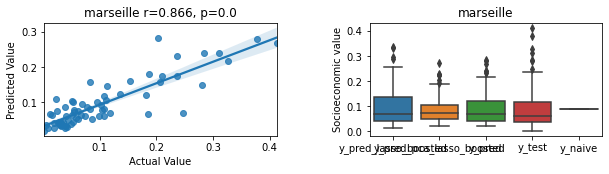

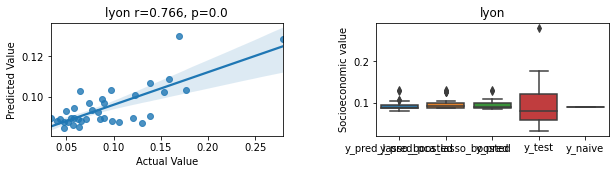

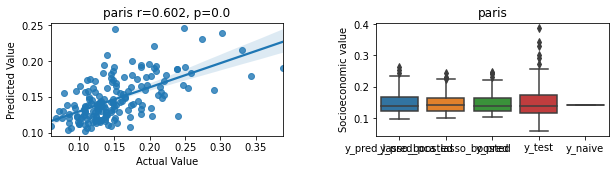

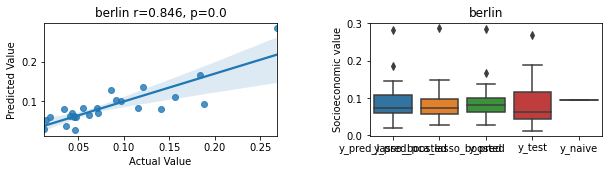

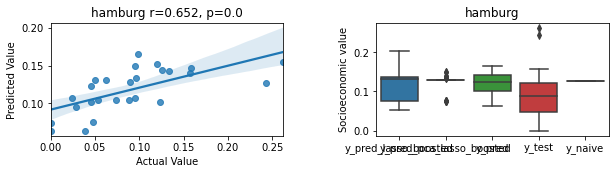

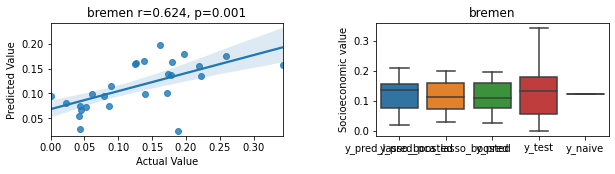

In [16]:
target = 'foreign_nationals'

# Marseille: lasso - boosted
city = 'marseille'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Lyon: lasso boosted:
city = 'lyon'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Paris: lasso boosted
city = 'paris'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Berlin: pca lasso boosted
city = 'berlin'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Hamburg: pca lasso:
city = 'hamburg'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Bremen: pca lasso improvement
city = 'bremen'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

marseille: 0.006852372650008013
lyon: 0.0030466485606701387
paris: 0.003525481614185443
berlin: 0.007237617425608052
hamburg: 0.00866035199948988
bremen: 0.005860062467446568


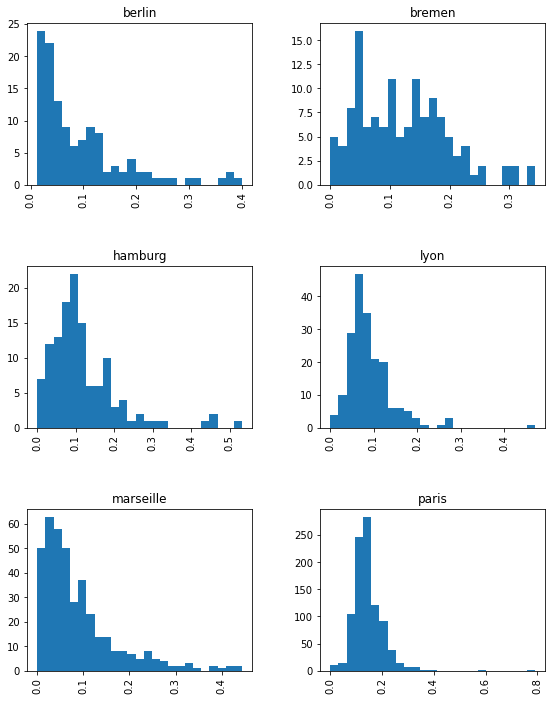

In [17]:
foreign_nationals = socios[socios.types == 'foreign_nationals']
fig = plt.figure(figsize = (9,12))
ax = fig.gca()
foreign_nationals.hist(column = 'relative_value', by='assigned_city', ax = ax, bins = 25)
for city in ['marseille', 'lyon', 'paris', 'berlin', 'hamburg', 'bremen']:
    print(str(city)+': '+str(foreign_nationals[foreign_nationals.assigned_city == city].relative_value.var()))

In [18]:
final_results = pd.DataFrame(columns = ['improvement','r2_score'])
target = 'foreign_nationals'

# Marseille: PCA-Lasso-Boosted
city = 'marseille'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Lyon: lasso-boosted
city = 'lyon'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

#Paris: lasso boosted
city = 'paris'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Berlin: Lasso boosted:
city = 'berlin'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Hamburg: Lasso boosted:
city = 'hamburg'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Bremen: Lasso boosted:
city = 'bremen'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

shape of training data (345, 243)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape of training data (345, 243)
shape of training data (176, 243)
0.1
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.2
shape of training data (176, 243)
shape of training data (868, 243)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape of training data (868, 243)
shape of training data (122, 243)
0.01
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.1
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.1
shape of training data 

In [19]:
final_results

,improvement,r2_score
marseille,72.405118,0.716842
lyon,27.669349,0.275161
paris,37.112783,0.357471
berlin,71.91532,0.70963
hamburg,38.981017,0.19445
bremen,36.291787,0.354828


## Income levels

shape of training data (345, 243)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape of training data (345, 243)
shape of training data (176, 243)
0.1
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.1
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.1
shape of training data (176, 243)
shape of training data (868, 243)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape of training data (868, 243)
shape of training data (122, 243)
0.1
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.1
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.1
shape of training data (

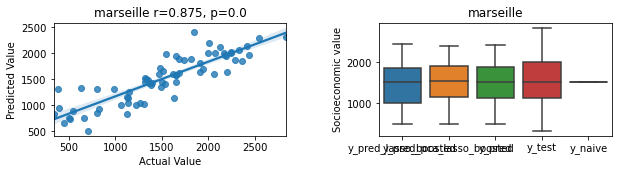

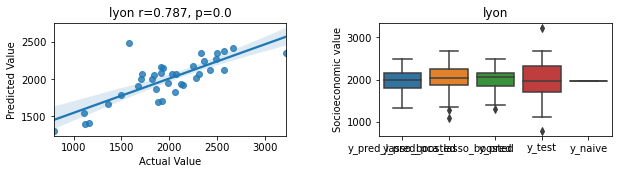

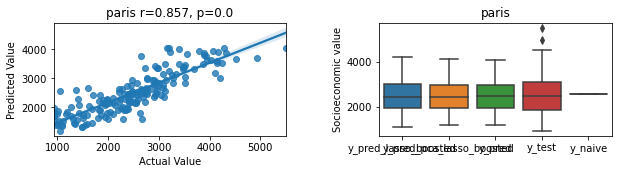

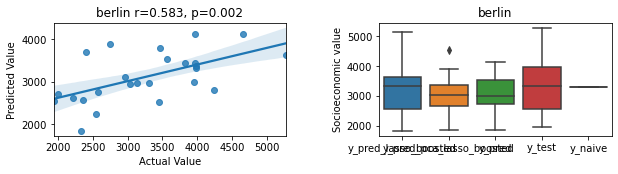

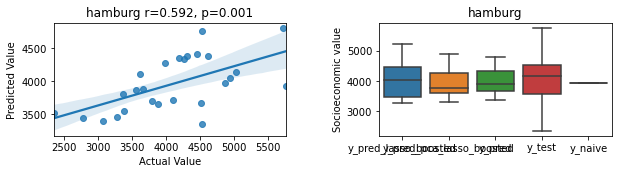

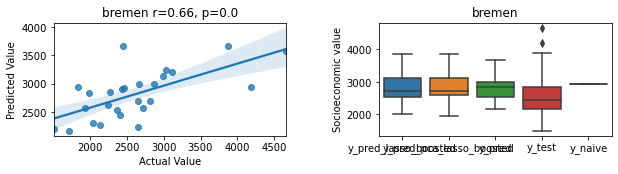

In [20]:
target = 'income_levels'

# Marseille: pca lasso
city = 'marseille'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Lyon: lasso boosted
city = 'lyon'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Paris: lasso boosted
city = 'paris'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Berlin: pca lasso boosted
city = 'berlin'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Hamburg: pca lasso
city = 'hamburg'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

# Bremen: lasso boosted
city = 'bremen'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
plot_result_correlation(predicts, city)

marseille: 380553.6292474696
lyon: 237952.59144344955
paris: 763183.5892529908
berlin: 773103.4125472107
hamburg: 785621.7799112091
bremen: 530236.1407336382


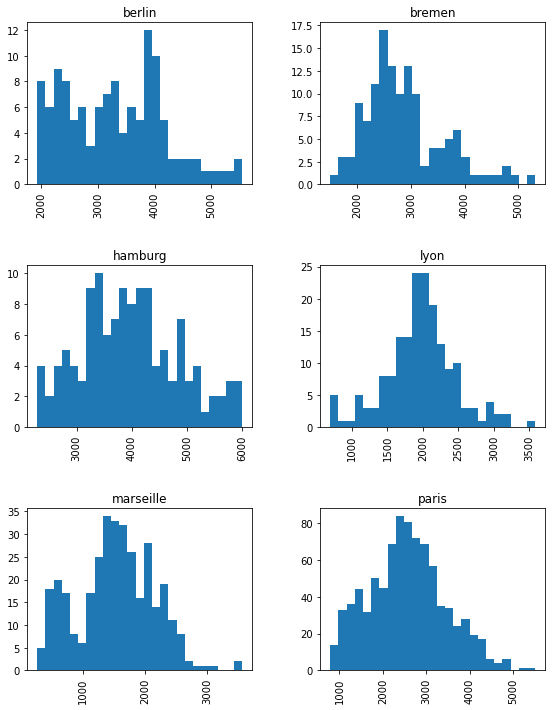

In [21]:
income_levels = socios[socios.types == 'income_levels']
fig = plt.figure(figsize = (9,12))
ax = fig.gca()
income_levels.hist(column = 'absolute_value', by='assigned_city', ax = ax, bins = 25)
for city in ['marseille', 'lyon', 'paris', 'berlin', 'hamburg', 'bremen']:
    print(str(city)+': '+str(income_levels[income_levels.assigned_city == city].absolute_value.var()))

In [22]:
final_results = pd.DataFrame(columns = ['improvement','r2_score'])
target = 'income_levels'

# Marseille: PCA-Lasso-Boosted
city = 'marseille'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Lyon: lasso-boosted
city = 'lyon'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

#Paris: lasso boosted
city = 'paris'
country = 'FR'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Berlin: Lasso boosted:
city = 'berlin'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Hamburg: Lasso boosted:
city = 'hamburg'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

# Bremen: Lasso boosted:
city = 'bremen'
country = 'DE'
agg = get_training_data(city, country,1000, 'count',  2015)
predicts = train_mean_model(agg, target, city, country)
final_results.loc[city, 'improvement'] = (100-(metrics.mean_squared_error(predicts.y_test, predicts.y_pred)/metrics.mean_squared_error(predicts.y_test, predicts.y_naive)*100))
final_results.loc[city, 'r2_score'] = metrics.r2_score(predicts.y_test, predicts.y_pred)

shape of training data (345, 243)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape before pca: (344, 236)
number of pca components: 69
shape after pca: (344, 69)
0.01
shape of training data (345, 243)
shape of training data (176, 243)
0.1
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.1
shape before pca: (176, 236)
number of pca components: 70
shape after pca: (176, 70)
0.1
shape of training data (176, 243)
shape of training data (868, 243)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape before pca: (861, 236)
number of pca components: 134
shape after pca: (861, 134)
0.01
shape of training data (868, 243)
shape of training data (122, 243)
0.1
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.1
shape before pca: (122, 236)
number of pca components: 71
shape after pca: (122, 71)
0.1
shape of training data (

In [23]:
final_results

,improvement,r2_score
marseille,75.309903,0.752903
lyon,57.652806,0.576165
paris,73.826264,0.736806
berlin,29.731272,0.296566
hamburg,33.939137,0.312069
bremen,45.940758,0.348394


## Selected columns

In [24]:
target = 'income_levels'
agg = get_training_data('paris', 'FR',1000, 'count',  2015)
cols = get_best_lasso_model(agg = agg, target=target, city='paris', country='FR', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns')

agg = get_training_data('marseille', 'FR',1000, 'count',  2015)
cols=cols+(get_best_lasso_model(agg = agg, target=target, city='marseille', country='FR', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('lyon', 'FR',1000, 'count',  2015)
cols=cols+(get_best_lasso_model(agg = agg, target=target, city='lyon', country='FR', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('berlin', 'DE',1000, 'count',  2015)
cols=cols+(get_best_lasso_model(agg = agg, target=target, city='berlin', country='DE', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('bremen', 'DE',1000, 'count',  2015)
cols=cols + (get_best_lasso_model(agg = agg, target=target, city='bremen', country='DE', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('hamburg', 'DE',1000, 'count',  2015)
cols=cols + (get_best_lasso_model(agg = agg, target=target, city='hamburg', country='DE', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

df1 = pd.Series(cols).value_counts().sort_index().reset_index().reset_index(drop=True)
df1.columns = ['Element', 'Frequency']
df1.sort_values(by='Frequency', ascending = False).head(15)

shape of training data (868, 243)
0.01
shape of training data (345, 243)
0.01
shape of training data (176, 243)
0.1
shape of training data (122, 243)
0.1
shape of training data (129, 243)
0.1
shape of training data (126, 243)
0.1


,Element,Frequency
106,swimming_pool_area_count_1000,4
3,attraction_area_count_1000,4
80,playground_area_count_1000,4
128,water_well_min_dist,3
63,mobile_phone_shop_area_count_1000,3
68,muslim_area_count_1000,3
69,muslim_min_dist,3
24,car_dealership_min_dist,3
21,camera_surveillance_area_count_1000,3
81,playground_min_dist,3


In [25]:
target = 'foreign_nationals'
agg = get_training_data('paris', 'FR',1000, 'count',  2015)
cols = get_best_lasso_model(agg = agg, target=target, city='paris', country='FR', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns')

agg = get_training_data('marseille', 'FR',1000, 'count',  2015)
cols=cols+(get_best_lasso_model(agg = agg, target=target, city='marseille', country='FR', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('lyon', 'FR',1000, 'count',  2015)
cols=cols+(get_best_lasso_model(agg = agg, target=target, city='lyon', country='FR', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('berlin', 'DE',1000, 'count',  2015)
cols=cols+(get_best_lasso_model(agg = agg, target=target, city='berlin', country='DE', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('bremen', 'DE',1000, 'count',  2015)
cols=cols + (get_best_lasso_model(agg = agg, target=target, city='bremen', country='DE', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('hamburg', 'DE',1000, 'count',  2015)
cols=cols + (get_best_lasso_model(agg = agg, target=target, city='hamburg', country='DE', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

df1 = pd.Series(cols).value_counts().sort_index().reset_index().reset_index(drop=True)
df1.columns = ['Element', 'Frequency']
df1.sort_values(by='Frequency', ascending = False).head(15)

shape of training data (868, 243)
0.01
shape of training data (345, 243)
0.01
shape of training data (176, 243)
0.1
shape of training data (122, 243)
0.01
shape of training data (129, 243)
0.1
shape of training data (126, 243)
0.6


,Element,Frequency
142,vending_parking_area_count_1000,5
33,clothes_area_count_1000,4
102,post_box_min_dist,4
84,muslim_area_count_1000,4
113,shoe_shop_area_count_1000,4
19,bus_stop_min_dist,4
57,fountain_area_count_1000,3
140,vending_any_area_count_1000,3
53,fast_food_min_dist,3
124,telephone_min_dist,3


In [26]:
target = 'unemployment_rate'
agg = get_training_data('paris', 'FR',1000, 'count',  2015)
cols = get_best_lasso_model(agg = agg, target=target, city='paris', country='FR', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns')

agg = get_training_data('marseille', 'FR',1000, 'count',  2015)
cols=cols+(get_best_lasso_model(agg = agg, target=target, city='marseille', country='FR', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('lyon', 'FR',1000, 'count',  2015)
cols=cols+(get_best_lasso_model(agg = agg, target=target, city='lyon', country='FR', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('berlin', 'DE',1000, 'count',  2015)
cols=cols+(get_best_lasso_model(agg = agg, target=target, city='berlin', country='DE', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('bremen', 'DE',1000, 'count',  2015)
cols=cols + (get_best_lasso_model(agg = agg, target=target, city='bremen', country='DE', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

agg = get_training_data('hamburg', 'DE',1000, 'count',  2015)
cols=cols + (get_best_lasso_model(agg = agg, target=target, city='hamburg', country='DE', socio_year=2015, scaled='all', density_type='count', radius = 1000, output = 'used_columns'))

df1 = pd.Series(cols).value_counts().sort_index().reset_index().reset_index(drop=True)
df1.columns = ['Element', 'Frequency']
df1.sort_values(by='Frequency', ascending = False).head(15)

shape of training data (868, 243)
0.01
shape of training data (345, 243)
0.1
shape of training data (176, 243)
0.2
shape of training data (122, 243)
0.1
shape of training data (129, 243)
0.2
shape of training data (126, 243)
0.1


,Element,Frequency
11,bus_stop_min_dist,4
62,parking_min_dist,3
61,parking_area_count_1000,3
54,muslim_min_dist,3
67,playground_min_dist,3
22,community_centre_area_count_1000,3
69,post_box_min_dist,2
77,school_min_dist,2
25,convenience_area_count_1000,2
82,supermarket_min_dist,2
